In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_path = 'data.csv' 
seq_length = 20           


try:
    df = pd.read_csv(csv_path).dropna(subset=['Magnitude'])
    print(f"✅ GERÇEK VERİ YÜKLENDİ: {len(df)} kayıt bulundu.")
except FileNotFoundError:
    raise FileNotFoundError("❌ HATA: 'data.csv' dosyası bulunamadı! Lütfen dosyayı notebook klasörüne at.")


data = df[['Magnitude']].values.astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, seq_length)
train_size = int(len(X) * 0.8)
X_train = torch.from_numpy(X[:train_size]).float().to(device)
y_train = torch.from_numpy(y[:train_size]).float().to(device)
X_test = torch.from_numpy(X[train_size:]).float().to(device)
y_test = torch.from_numpy(y[train_size:]).float().to(device)

all_results = {}
all_preds = {}


def train_and_eval(name, model, epochs=100):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        preds = model(X_test).cpu().numpy()
    
    preds_real = scaler.inverse_transform(preds)
    y_real = scaler.inverse_transform(y_test.cpu().numpy())
    
    mse = mean_squared_error(y_real, preds_real)
    r2 = r2_score(y_real, preds_real)
    all_results[name] = [mse, r2]
    all_preds[name] = preds_real
    
    
    plt.figure(figsize=(10, 4))
    plt.plot(y_real[-100:], label='Gerçek (Real)', color='black', linewidth=2)
    plt.plot(preds_real[-100:], label=f'{name} Tahmini', color='red', linestyle='--')
    plt.title(f"{name} Modeli Performansı (Gerçek Veri)")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()
    
    print(f"📊 {name} -> MSE: {mse:.4f}, R2: {r2:.4f}")
    return y_real

✅ GERÇEK VERİ YÜKLENDİ: 31916 kayıt bulundu.


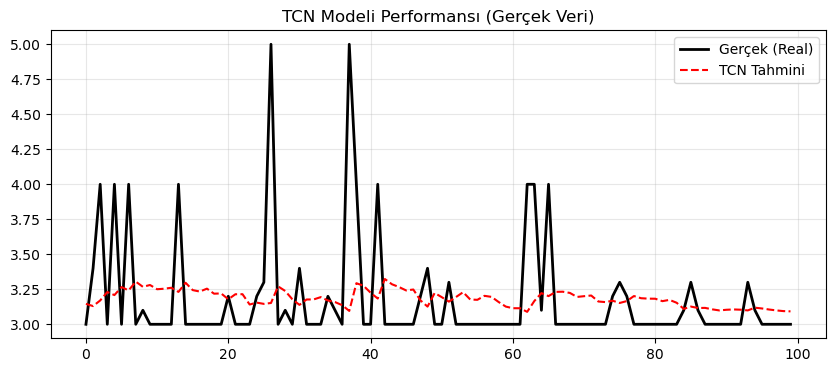

📊 TCN -> MSE: 0.1514, R2: 0.1060


In [7]:
class ModelTCN(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=2, dilation=2)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=4, dilation=4)
        dummy = torch.zeros(1, 1, seq_length)
        self.flat_size = F.relu(self.conv2(F.relu(self.conv1(dummy)))).view(1, -1).size(1)
        self.fc = nn.Linear(self.flat_size, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.fc(x.flatten(1))

_ = train_and_eval("TCN", ModelTCN())


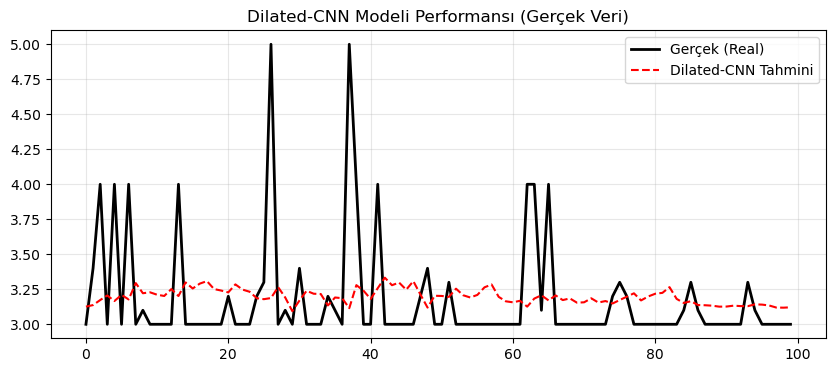

📊 Dilated-CNN -> MSE: 0.1517, R2: 0.1037


In [5]:
class ModelDilatedCNN(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        # Dilation=2 ile görüş alanını genişletiyoruz
        self.conv = nn.Conv1d(input_size, 64, kernel_size=3, dilation=2, padding=2)
        with torch.no_grad():
            dummy = torch.zeros(1, input_size, seq_length)
            dummy = self.conv(dummy)
            self.flat_size = dummy.view(1, -1).size(1)
        self.fc = nn.Linear(self.flat_size, 1) 
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv(x))
        return self.fc(x.flatten(1))

_ = train_and_eval("Dilated-CNN", ModelDilatedCNN())